# Intersection with a crosswalk

**Load dependencies**

In [1]:
using Revise
using Random
using Printf
using DataStructures
using Flux
using POMDPs
using POMDPModelTools
using POMDPSimulators
using BeliefUpdaters
using POMDPPolicies
using DiscreteValueIteration
using MDPModelChecking
using StaticArrays
using RLInterface
using DeepQLearning
using AutomotiveDrivingModels
using AutomotivePOMDPs
using AutomotiveSensors
using LocalApproximationValueIteration
using Reel
using AutoViz
using ProgressMeter
using JLD2
using FileIO
using BSON
using PedCar

loaded


┌ Info: Precompiling DiscreteValueIteration [4b033969-44f6-5439-a48b-c11fa3648068]
└ @ Base loading.jl:1186
┌ Info: Precompiling MDPModelChecking [abefb91b-a28c-5ab9-9bd9-026e532d7b0e]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/AutomotivePOMDPs/L1lsd.ji for AutomotivePOMDPs [dca8afc0-c686-11e8-0934-712707da73aa]
└ @ Base loading.jl:1184
┌ Warning: Module DiscreteValueIteration with build ID 291671178944001 is missing from the cache.
│ This may mean DiscreteValueIteration [4b033969-44f6-5439-a48b-c11fa3648068] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:941
┌ Info: Recompiling stale cache file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/PedCar/NmDDZ.ji for PedCar [90cf7f26-d5c7-593d-a0e1-4a8367407571]
└ @ Base loading.jl:1184
┌ Warning: Module AutomotivePOMDPs with build ID 291697359647096 is missing from the cache.
│ This may mean AutomotivePOMDPs [dca8afc0-c686-11e8-0934-712

In [2]:
includet("../src/masking.jl")
includet("../src/masked_dqn.jl")
includet("../src/qmdp_approximation.jl")
includet("../src/decomposed_tracking.jl")
includet("../src/decomposition.jl")
includet("../src/util.jl")
includet("../src/render_helpers.jl")

In [3]:
rng = MersenneTwister(1);
cam = FitToContentCamera(0.);

## Scenario

In [4]:
params = UrbanParams(nlanes_main=1,
                     crosswalk_pos =[VecSE2(6, 0., pi/2), VecSE2(-6, 0., pi/2), VecSE2(0., -5., 0.)],
                     crosswalk_length =  [14.0, 14., 14.0],
                     crosswalk_width = [4.0, 4.0, 3.1],
                     stop_line = 22.0)
env = UrbanEnv(params=params);

** Discrete states MDP **

In [5]:
mdp = PedCarMDP(env=env, pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7);
init_transition!(mdp);

In [6]:
@printf("spatial resolution %2.1f m \n", mdp.pos_res)
@printf("pedestrian velocity resolution %2.1f m/s \n", mdp.vel_ped_res)
@printf("car velocity resolution %2.1f m/s \n", mdp.vel_res)
@printf("number of states %d \n", n_states(mdp))
@printf("number of actions %d \n", n_actions(mdp))

spatial resolution 2.0 m 
pedestrian velocity resolution 1.0 m/s 
car velocity resolution 2.0 m/s 
number of states 23456940 
number of actions 4 


**Continuous states MDP**

In [7]:
pomdp = UrbanPOMDP(env=env,
                   sensor = PerfectSensor(),
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.7, 
                   ped_birth=0.7, 
                   max_obstacles=0., # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);

## Load policies

In [8]:
@load "../pc_util_processed.jld2" qmat util pol
safe_policy = ValueIterationPolicy(mdp, qmat, util, pol);

In [9]:
threshold = 0.99
mask = SafetyMask(mdp, safe_policy, threshold);
continuous_safe_policy = SafePOMDPPolicy(mask, pomdp)
discrete_safe_random = MaskedEpsGreedyPolicy(mdp, 1.0, mask, rng)
continuous_safe_random = RandomMaskedPOMDPPolicy(mask, pomdp, rng);

In [10]:
qnetwork = BSON.load("../training_scripts/drqn-log/log20/model.bson")[:qnetwork]
weights = BSON.load("../training_scripts/drqn-log/log20/qnetwork.bson")[:qnetwork]
Flux.loadparams!(qnetwork, weights)
dqn_policy = NNPolicy(pomdp, qnetwork, actions(pomdp), 1)
masked_policy = MaskedNNPolicy(pomdp, dqn_policy, mask);

# Evaluation

**Discrete Environment: Safe Policy**

In [27]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, safe_policy, n_ep=10000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

 49.799191 seconds (85.13 M allocations: 13.086 GiB, 7.09% gc time)
Summary for 10000 episodes: 
Average reward: 0.140 
Average # of steps: 62.053 
Average # of violations: 0.000 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


**Discrete Environment: Safe Random**

In [28]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(mdp, discrete_safe_random, n_ep=10000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

 90.058251 seconds (218.71 M allocations: 26.146 GiB, 8.40% gc time)
Summary for 10000 episodes: 
Average reward: 0.046 
Average # of steps: 89.810 
Average # of violations: 1.820 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


**Continuous Environment: Safe Policy**

In [29]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, continuous_safe_policy, n_ep=1000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:01

711.440730 seconds (3.11 G allocations: 228.324 GiB, 17.27% gc time)
Summary for 1000 episodes: 
Average reward: 0.002 
Average # of steps: 242.466 
Average # of violations: 0.000 


Progress: 100%|█████████████████████████████████████████| Time: 0:11:51


**Continuous Environment: Safe Random**

In [14]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, continuous_safe_random, n_ep=1000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:01

981.297739 seconds (5.36 G allocations: 390.018 GiB, 13.89% gc time)
Summary for 1000 episodes: 
Average reward: 0.000 
Average # of steps: 385.710 
Average # of violations: 0.000 


Progress: 100%|█████████████████████████████████████████| Time: 0:16:21


###### **Continuous Environment: Safe RL**

In [30]:
@time rewards_mask, steps_mask, violations_mask = evaluation_loop(pomdp, masked_policy, n_ep=1000, max_steps=400, rng=rng);
print_summary(rewards_mask, steps_mask, violations_mask)

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

343.845547 seconds (1.26 G allocations: 91.655 GiB, 15.52% gc time)
Summary for 1000 episodes: 
Average reward: 0.017 
Average # of steps: 116.405 
Average # of violations: 0.100 


Progress: 100%|█████████████████████████████████████████| Time: 0:05:44


In [17]:
evaluation_policy = masked_evaluation(mask)
scores_eval = DeepQLearning.evaluation(evaluation_policy, dqn_policy, POMDPEnvironment(pomdp),                                  
                         1000,
                         400,
                         true)

Evaluation ... Avg Reward 0.98 | Violations (%) 0.20 | Avg Steps 116.02

0.979

**Collisions analysis**

In [11]:
test_policy = masked_policy;

In [16]:
hr = HistoryRecorder(rng=rng, max_steps=400)
s0 = initialstate(pomdp, rng)
up = PreviousObservationUpdater()
o0 = generate_o(pomdp, s0, UrbanAction(0.), s0, rng)
b0 = initialize_belief(up, o0)
@time hist2 = simulate(hr, pomdp, test_policy, up, b0, s0);

  0.210581 seconds (732.30 k allocations: 54.844 MiB, 36.61% gc time)


In [17]:
function POMDPModelTools.generate_sori(pomdp::UrbanPOMDP, s::Scene, a::UrbanAction, rng::AbstractRNG)
    sp, o, r = generate_sor(pomdp, s, a, rng)
    return sp, o, r, deepcopy(pomdp.models)
end

In [12]:
function find_collision(pomdp, test_policy, rng)
    up = PreviousObservationUpdater()
    @showprogress for ep=1:10000
        hr = HistoryRecorder(rng=rng, max_steps=400)
        s0 = initialstate(pomdp, rng)
        o0 = generate_o(pomdp, s0, UrbanAction(0.), s0, rng)
        b0 = initialize_belief(up, o0)
        hist2 = simulate(hr, pomdp, test_policy, up, b0, s0)
        if sum(hist2.reward_hist .< 0.) != 0.
            println("Crash")
            return hist2
        end
    end
    return hist2 
end
hist2 = find_collision(pomdp, test_policy, rng);

Progress:  37%|███████████████                          |  ETA: 0:24:51m

Crash


Progress: 100%|█████████████████████████████████████████| Time: 0:14:28


In [13]:
h = hist2
state_hist = h.state_hist
action_hist = h.action_hist
belief_hist = h.belief_hist
safe_acts = [i[1] for i in h.ainfo_hist]
probas = [i[2] for i in h.ainfo_hist]
routes = [i[3] for i in h.ainfo_hist]

push!(safe_acts, [UrbanAction(NaN)])
push!(probas, [NaN])
push!(routes, PedCar.OFF_ROUTE)
push!(action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, belief_hist, safe_acts, probas, routes, mask, interp=true, obsviz=true)
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpIL2hzk", 0x000000000000014c, 20.0, nothing)

In [14]:
hist = hist2
step = 318
s = hist.state_hist[step]
models = hist.info_hist[step]
o = generate_o(pomdp, s, rng);

In [22]:
veh.state.v

4.925162298159967

In [15]:
hist = hist2
step = 318
s = hist.state_hist[step]
vehid = 2
veh = s[findfirst(vehid, s)]
m = hist.info_hist[step][vehid]
cwid = 2
cwm = m.crosswalk_drivers[cwid]
intm = m.intersection_driver

[l.tag for l in intm.navigator.route]

MethodError: MethodError: no method matching getindex(::Nothing, ::Int64)
Closest candidates are:
  getindex(::Any, !Matched::AbstractTrees.ImplicitRootState) at /mnt/c/Users/Maxime/wsl/.julia/packages/AbstractTrees/gbHmA/src/AbstractTrees.jl:344

In [18]:
s_mdp = get_mdp_state(mdp, pomdp.models, s, 101, 2)
s_itp, w_itp = interpolate_state(mdp, s_mdp)
sdisc = s_itp[argmax(w_itp)]

PedCarMDPState(false, VehicleState(VecSE2({0.108, -0.344}, 2.298), Frenet(RoadIndex({12, 0.111909}, {13, 1}), 4.000, 0.000, 0.000), 2.000), VehicleState(VecSE2({-6.000, -1.000}, 1.571), Frenet(RoadIndex({1, 0.428571}, {18, 1}), 6.000, 0.000, 0.000), 1.000), VehicleState(VecSE2({24.000, 1.500}, 3.142), Frenet(RoadIndex({1, 0.250000}, {1, 1}), 6.000, 0.000, 0.000), 4.000), LaneTag[LaneTag(1, 1), LaneTag(5, 1)])

In [43]:
AutomotivePOMDPs.is_intersection_clogged(intm, s, env.roadway, vehid)
AutomotivePOMDPs.engaged(intm, s, env.roadway, vehid)
AutomotiveDrivingModels.observe!(deepcopy(intm), s, env.roadway, vehid)

Vehicle 2 : emergency break
veh 2 | clogged true | passed false | engaged true | stop false| right of way true


TTCIntersectionDriver
  a: LonAccelDirection
  navigator: RouteFollowingIDM
  intersection: Array{Lane}((2,))
  intersection_pos: VecSE2{Float64}
  ttc_threshold: Float64 3.0
  horizon: Float64 20.0
  stop_delta: Float64 4.0
  accel_tol: Float64 0.0
  priorities: Dict{Tuple{LaneTag,LaneTag},Bool}
  priority: Bool false
  stop: Bool true


┌ Warning: /home/maxime/Maxime/OneDrive - Leland Stanford Junior University/Research/AutomotivePOMDPs/src/driver_models is not an existing directory, Revise is not watching
└ @ Revise /mnt/c/Users/Maxime/wsl/.julia/packages/Revise/TmjcT/src/Revise.jl:361


In [42]:
s[2]

Vehicle(2, VehicleState(VecSE2({4.349, 1.500}, 3.142), Frenet(RoadIndex({1, 0.137579}, {7, 1}), 1.651, 0.000, 0.000), 2.200), VehicleDef(CAR, 4.000, 1.800))

### Collision analysis in the discrete MDP

In [49]:
hr = HistoryRecorder(rng=rng, max_steps=400)
s0 = initialstate(mdp, rng)
@time hist2 = simulate(hr, mdp, discrete_safe_random, s0);

  0.296488 seconds (162.34 k allocations: 9.622 MiB)


In [47]:
function find_collision(mdp::MDP, test_policy, rng)
    @showprogress for ep=1:10000
        hr = HistoryRecorder(rng=rng, max_steps=400)
        s0 = initialstate(mdp, rng)
        hist2 = simulate(hr, mdp, test_policy, s0);
        if sum(hist2.reward_hist .< 0.) != 0.
            println("Crash")
            return hist2
        end
    end
    return hist2
end
hist2 = find_collision(mdp, safe_policy, rng);

Progress:  35%|██████████████                           |  ETA: 0:22:44

Crash


Progress: 100%|█████████████████████████████████████████| Time: 0:12:02


In [50]:
push!(hist2.action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(mdp, hist2.state_hist, hist2.action_hist, mask, overlays=SceneOverlay[IDOverlay()])
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Frames{MIME{Symbol("image/png")}}("/tmp/tmpB62XHi", 0x0000000000000056, 4.0, nothing)

## Analyze value at custom state

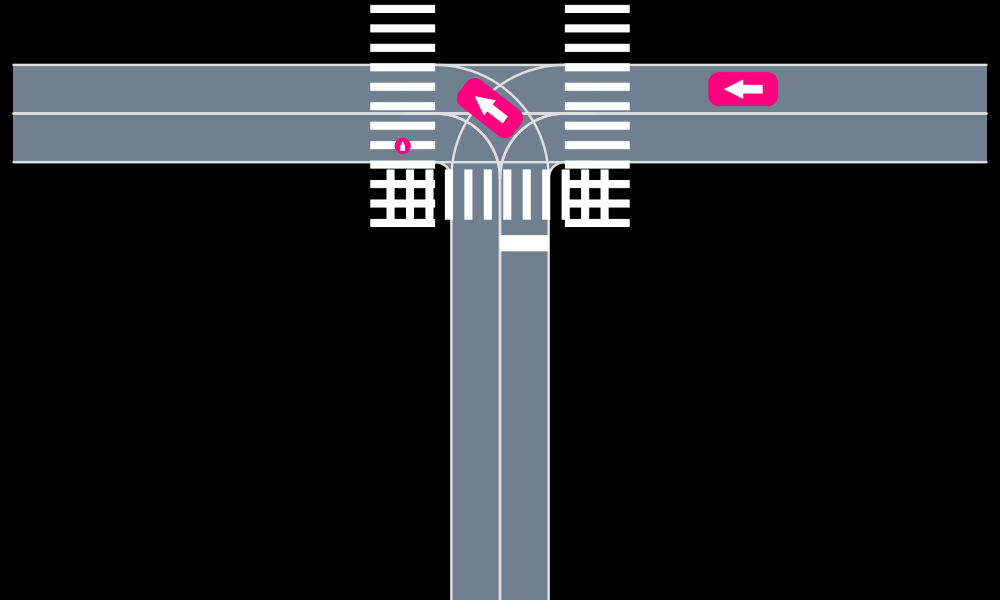

In [76]:
# Set car parameter
car_on = true
car_s0 = 15.
car_v0 = 6.
car_posF = Frenet(env.roadway[LaneTag(1, 1)], car_s0)
car = Vehicle(VehicleState(car_posF, env.roadway, car_v0), pomdp.car_type, 2)

# Set pedestrian parameter
ped_on = false
ped_s0 = 5.
ped_v0 = 0.
ped_posF = Frenet(env.ped_roadway[LaneTag(18,1)], ped_s0, 0., 0.) # choose between 17, 18, 19
ped = Vehicle(VehicleState(ped_posF, env.roadway, ped_v0), pomdp.ped_type, 101)

# Set ego vehicle 
ego_s0 = 5.
ego_v0 = 0.
ego_posF = Frenet(env.roadway[LaneTag(13, 1)], ego_s0)
ego = Vehicle(VehicleState(ego_posF, env.roadway, ego_v0), pomdp.car_type, 1)

s_mdp = PedCarMDPState(false, ego.state, ped.state, car.state, SVector(LaneTag(1,1), LaneTag(2,1)))
itp_s, itp_weight = interpolate_state(mdp, s_mdp)
s_mdp = itp_s[argmax(itp_weight)]

s = Scene()
push!(s, car)
push!(s, ped)
push!(s, ego)

AutoViz.render(s, env, cam=cam)

In [31]:
hr = HistoryRecorder(rng=rng, max_steps=400)
s0 = sdisc
@time hist2 = simulate(hr, mdp, FunctionPolicy(s->UrbanAction(-4.0)), s0);
push!(hist2.action_hist, UrbanAction(NaN))
duration, fps, render_hist = animate_states(mdp, hist2.state_hist, hist2.action_hist, mask, overlays=SceneOverlay[IDOverlay()])
speed_factor = 2
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

  0.224134 seconds (91.07 k allocations: 6.063 MiB, 7.57% gc time)


Frames{MIME{Symbol("image/png")}}("/tmp/tmpSqiXOB", 0x0000000000000191, 4.0, nothing)

In [46]:
# o = generate_o(pomdp, s, rng)
o = hist2.observation_hist[18]
s = hist2.state_hist[19]
ego = s[findfirst(EGO_ID, s)]
car = s[findfirst(CAR_ID, s)]
ped = s[findfirst(PED_ID, s)]
println(ego)
scene = Scene()
push!(scene, ego)
push!(scene, car)
push!(scene, Vehicle(VehicleState(ped_posF, env.roadway, ped_v0), pomdp.ped_type, 101))

SystemError: SystemError: opening file /mnt/c/Users/Maxime/wsl/.julia/compiled/v1.0/PedCar/NmDDZ.ji: No such file or directory

In [26]:
o = generate_o(pomdp, s, rng)
a, ai = action_info(continuous_safe_policy, o)
sa, probs, route = ai
println("Probas ", probs)

Probas [0.998689, 0.998689, 0.998689, 0.995578]


In [99]:
ped.state.posG

3-element VecSE2{Float64}:
 6.0               
 3.0000000000000018
 1.5707963267948966

In [75]:
car.state.posG

3-element VecSE2{Float64}:
 26.000000000000004
 -1.5              
  0.0              